# Assignment 2: Wave buoy data analysis

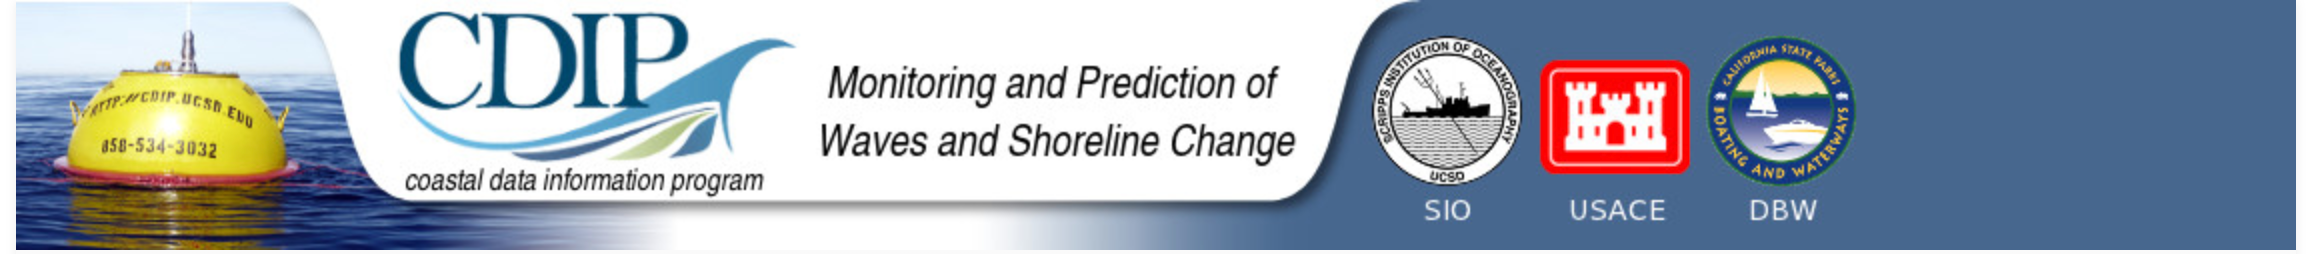

In this assignment, we will work with (REAL!) ocean wave data from the CDIP (coastal data information program) website , and analyze wave statistics such as the wave elevation distribution, wave height distribution, and other statistical quantities such as significant wave height. Through these exercises you will not only learn (or review) concepts of statistics, but also better understand the concepts of wave physics covered in the past few lectures.

__Key concepts__:
* Gaussian distribution; mean and variation
* Wave elevation distribution
* Wave height distribution
* Significant wave height (Hs)

__A few reminders__:
* Work on the Adroit Vis node since we need to retrieve data from the online database.
* Use the env330 kernel to ensure that you have all the necessary packages.
* List your group members and the buoy stations you choose at the beginning of the notebook.
* Always put labels on every plot you make. 
* If you can make all the plots in the notebook (you might need to write a few for loops and/or some functions), feel free to submit only the pdf converted from the notebook. There is also the option of saving individual figures (data), plotting them outside of jupyter notebook with whatever software you feel comfortable with, and include them in an additional pdf. 

__Group members__:             </br>
__Buoy stations__:

In [1]:
''' Include necessary python packages '''
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mpldts
import calendar
import scipy.signal as sig
from scipy.stats import norm  

# Part 1: Understand Gaussian (normal) distribution

Sample size = 1000, sample mean = 0.0119534, sample std = 0.976685
Sample size = 10000, sample mean = 0.0069209, sample std = 0.995843
Sample size = 100000, sample mean = -0.00196624, sample std = 0.999082


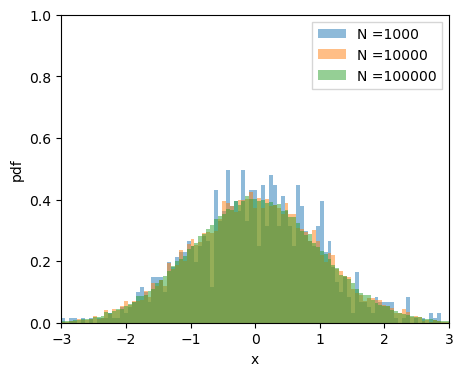

In [2]:
# Draw samples from the normal distribution
# Documentation of scipy.stats.norm: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

fig = plt.figure(figsize=[5,4])

# Spefify the mean and standard deviation 
mean = 0
sigma = 1

for N in (1000,10000,100000): 
    r = norm.rvs(size=N, loc=mean, scale=sigma) # draw samples from the normal distribution
    bins = np.linspace(-3,3,num=100) # bins to plot the histogram
    plt.hist(r, density=True, bins=bins, histtype='stepfilled', alpha=0.5, label = 'N =%g' %N) 
    mean_s = np.average(r) 
    sigma_s = np.var(r)**0.5
    print('Sample size = %g, sample mean = %g, sample std = %g' %(N, mean_s, sigma_s))
    
plt.xlim([-3,3]); plt.xlabel('x')
plt.ylim([0,1]); plt.ylabel('pdf')
plt.legend(fancybox=False, loc='upper right')
plt.show()

<div class="alert alert-info"><h1>Exercise 1: Gaussian (normal) distributions, means and variations  </h1></div>

1. Write out the mathematic formula of a Gaussian distribution. [How to write math equations in markdown](https://jupyterbook.org/en/stable/content/math.html#:~:text=To%20insert%20in%2Dline%20math,n%20l%20i%20n%20e%20.).
2. Plot a few Gaussian distribution curves with different means and standard deviations.
3. Show that you could normalize (overlap) the curves with their means and standard deviations.

# Part 2: wave gauge data from CDIP

### The data source
Buoy data are stored on the CDIP THREDDS server in NetCDF files. The XYZ Displacement data are available in two seperate locations:
* __Archive__ (previous deployments). You can __check if data from one particular station and deployment is available__ in this [archive catalog](https://thredds.cdip.ucsd.edu/thredds/catalog/cdip/archive/catalog.html).
* __Realtime__ (currently active deployment). You can __check if data from one particular station is available__ in this [realtime catalog](https://thredds.cdip.ucsd.edu/thredds/catalog/cdip/realtime/catalog.html). No deployment number is not necessary to identify the file as this is the current deployment.


<div class="alert alert-info"><h1>Exercise 2: analyzing wave signal from a buoy of choice </h1></div>

Choose a station from the following list (notice that some of these stations may only have realtime or archived data, and you still need to specify deployment number):
* HILO, HAWAII, HI - 188  
* PEARL HARBOR ENTRANCE, HI - 233  
* KANEOHE BAY, HI - 198 
* SCRIPPS PIER, CA - 073
* SANTA CRUZ BASIN, CA - 203  
* POINT SUR, CA - 157  
* GRAYS HARBOR, WA - 036  
* CAPE COD BAY, MA - 221  
* BARNEGAT, NJ - 209 
* FERNANDINA BEACH, FL - 132  
* MASONBORO INLET, ILM2, NC - 150  
* VIRGINIA BEACH OFFSHORE, VA - 171  

and perform the following analyses. You are also welcome to choose stations outside this list if you feel particularly inclined to. The cells below only provide the basic workflow and help functions so feel free to experiment with and modify them.

In [3]:
''' Some helper functions '''
# Convert to unix timestamp
def get_unix_timestamp(human_time,dateFormat):
    unix_timestamp = int(calendar.timegm(datetime.datetime.strptime(human_time, dateFormat).timetuple()))
    return unix_timestamp

# Convert to human readable timestamp
def get_human_timestamp(unix_timestamp, dateFormat):
    human_timestamp = datetime.datetime.utcfromtimestamp(int(unix_timestamp)).strftime(dateFormat)
    return human_timestamp

''' 
A function that retrive the data 
    Input: the station, deployment, start time, duration, etc...
    Ouput: time sequences of x, y, z, station title, sample time array, and sample rate (for Fourier analysis)
           also print out the beginning and the end data of the available data period
'''
def retrieve_data (stn, dataset, deploy, start_date, duration, qc_level):
    # if archive
    data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/' + stn + 'p1/' + stn + 'p1_d' + deploy + '.nc'
    # if realtime
    if dataset == 'realtime':
        data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/' + stn + 'p1_xy.nc'
   
    nc = netCDF4.Dataset(data_url)
    nc.set_auto_mask(False) # Turn off auto masking
    
    xdisp = nc.variables['xyzXDisplacement'] # Make a numpy array of three directional displacement variables (x, y, z)
    ydisp = nc.variables['xyzYDisplacement']
    zdisp = nc.variables['xyzZDisplacement']
    qc_flag = nc.variables['xyzFlagPrimary']
    filter_delay = nc.variables['xyzFilterDelay']
    start_time = nc.variables['xyzStartTime'][:] # Variable that gives start time for buoy data collection
    sample_rate = nc.variables['xyzSampleRate'][:] # Variable that gives rate (frequency, Hz) of sampling
    end_time = start_time + (len(xdisp)/sample_rate) # Calulate end time for buoy data collection

    # Get station name and number for plot title
    station_name = nc.variables['metaStationName'][:]
    station_title = station_name.tobytes().decode().split('\x00',1)[0]

    data_start = get_human_timestamp(start_time - filter_delay[0],"%m/%d/%Y %H:%M:%S")
    data_end = get_human_timestamp(end_time - filter_delay[0],"%m/%d/%Y %H:%M:%S")
    print("data avail start: " + data_start)
    print("  data avail end: " + data_end)
    
    # Find UNIX timestamps for user human-formatted start/end dates
    unix_start = get_unix_timestamp(start_date,"%m/%d/%Y %H:%M") 
    unix_end = unix_start + (duration * 60) # Create UNIX end stamp by adding duration to 'unix_start'

    # Create specialized array using UNIX Start and End times minus Filter Delay, and Sampling Period (1/sample_rate) 
    # to calculate sub-second time values that correspond to Z-Displacement sampling values
    # Adjust for the filter delay to get the actual displacement time.
    sample_time = np.arange((start_time - filter_delay[0]), end_time - filter_delay[0],(1/(sample_rate)))

    # Find corresponding start/end date index numbers in 'sample_time' array    
    start_index = sample_time.searchsorted(unix_start) 
    end_index = sample_time.searchsorted(unix_end)
    
    # Make array that only encompasses specified timerange
    sample_time_cut = sample_time[start_index:end_index]
    # Transform 'sample_time_cut' array into Datetime objects so that time component can be plotted as timestamps
    # Multiply sample_time_cut*1000 to remove sub-second decimal place and incorporate millisecond steps
    # Call 'sample_time_cut' datetime objects as '[ms]'
    # Convert to datetime objects for plotting
    sample_time_cut *= 1000
    sample_t_cut_ms = sample_time_cut.astype('datetime64[ms]').astype(datetime.datetime)

    # Limit data to date/times
    x = xdisp[start_index:end_index]
    y = ydisp[start_index:end_index]
    z = zdisp[start_index:end_index]
    qc = qc_flag[start_index:end_index]

    # Filter out by quality control level
    x = np.ma.masked_where(qc>qc_level,x)
    y = np.ma.masked_where(qc>qc_level,y)
    z = np.ma.masked_where(qc>qc_level,z)
    
    return x, y, z, station_title, sample_t_cut_ms, sample_rate


### Retrieve the data
Specify the following:
* CDIP Buoy station number 
* Realtime or archive 
* Deployment number (archive only)
* Date and plot duration (minutes)
* Option to set quality control (QC) flag level based on the level of qc data you want to plot. 
    * QC flag categories: [1,2,3,4,9] = [good,not_evaluated,questionable,bad,missing]
    
and call the `retrieve_data` function, which returns the time sequences of x, y, z displacement, station title, sample time array, and sample rate (for Fourier analysis). It also print out during which period the data is available.

In [ ]:
''' If using archive data, specify deployment as well '''
stn = '188' # CDIP Buoy station number
dataset = 'archive' # Enter 'archive' or 'realtime'
deploy = '06' # If archive dataset, set deployment number from .nc file
start_date = '09/30/2015 09:00' # MM/DD/YYYY HH:MM
duration  = 30 # Set length of timeseries (minutes) - KEY THING TO CHANGE HERE FOR PSET
qc_level = 2 # Filter data with qc flags above this number 

x, y, z, station_title, sample_t_cut_ms, sample_rate = retrieve_data (stn, dataset, deploy, start_date, duration, qc_level)

In [ ]:
''' If using realtime data, no need to specify deployment '''
stn = '188' # CDIP Buoy station number
dataset = 'realtime' # Enter 'archive' or 'realtime'
deploy = 'none'
start_date = '02/09/2023 9:00' # MM/DD/YYYY HH:MM
duration  = 30 # Set length of timeseries (minutes) - KEY THING TO CHANGE HERE FOR PSET
qc_level = 2 # Filter data with qc flags above this number 

x, y, z, station_title, sample_t_cut_ms, sample_rate = retrieve_data (stn, dataset, deploy, start_date, duration, qc_level)

### Visualize the displacement time series 

In [ ]:
''' The following cell visualizes the buoy displacement sequence. 
    Notice that you only need to work with z displacement. '''
fig = plt.figure(figsize=(15,15))

# Create 3 stacked subplots for three Directional Displacement Parameters (xyz)
plt_x = plt.subplot(3,1,1)
plt_x.plot(sample_t_cut_ms,x,'b')
plt_y = plt.subplot(3,1,2, sharex=plt_x)
plt_y.plot(sample_t_cut_ms,y,'b')
plt_z = plt.subplot(3,1,3, sharex=plt_x)
plt_z.plot(sample_t_cut_ms,z,'g')

# Set titles
plt.suptitle(station_title + "\n" + "Time: " + start_date, fontsize=22, y=0.97)

# Set x-axis tick format to "HH:MM:SS" and tick interval to every 5 minutes
#days = mpldts.MinuteLocator(interval=5) 
daysFmt = mpldts.DateFormatter('%H:%M:%S')
#plt.gca().xaxis.set_major_locator(days)
plt.gca().xaxis.set_major_formatter(daysFmt)

ymin=np.floor(min(min(x), min(y), min(z)))
ymax=np.ceil(max(max(x), max(y), max(z)))

# Set y-axis limits for each plot
plt_x.set_ylim(ymin,ymax)
plt_y.set_ylim(ymin,ymax)
plt_z.set_ylim(ymin,ymax)

# Label each subplot title
plt_x.set_title('North/South Displacement', fontsize=14)
plt_y.set_title('East/West Displacement', fontsize=14)
plt_z.set_title('Vertical Displacement', fontsize=14,y=1)

# Label each y-axis
plt_x.set_ylabel('X Displacement (m)', fontsize=14)
plt_y.set_ylabel('Y Displacement (m)', fontsize=14)
plt_z.set_ylabel('Z Displacement (m)', fontsize=14)

# Label x-axis
plt.xlabel('Time (UTC)', fontsize=18)

# Plot dashed gridlines
plt_x.grid(axis='y', which='major', color='b', linestyle='-', alpha=0.25)
plt_y.grid(axis='y', which='major', color='b', linestyle='-', alpha=0.25)
plt_z.grid(axis='y', which='major', color='g', linestyle='-', alpha=0.25)

### Plot the wave elevation distribution 

In [ ]:
''' Specify the following for the plot '''
num_bins = 30 # number of bins for the histogram

In [ ]:
# compute and plot distribution of wave elevations
fig = plt.figure(figsize=[5,4]); ax = plt.gca()

elev_bins = np.linspace(-3, 3, num=num_bins, endpoint=True) # wave elevation bins in the unit of m 
pdf, bins = np.histogram(z, bins=elev_bins, density=True)
bin_width = bins[1:] - bins[:-1] 
bin_centers = (bins[:-1] + bin_width/2)

# Plot the discrete pdf from the binned wave elevation
ax.plot(bin_centers, pdf, 'o', markersize=5, markerfacecolor="None", markeredgewidth=1,
        label = 'data') 

# Plot the Gaussian distribution given by the mean and standard deviation of the data
mean = np.average(z); sigma = np.std(z)
print('Sample size: %g, mean: %g, std: %g' %(len(z), mean, sigma))
eta_smooth = np.linspace(-3, 3, num=1000, endpoint=True) # Use many points for a smooth curve
ax.plot(eta_smooth, norm.pdf(eta_smooth, loc=mean, scale=sigma), label = 'Gaussian')

ax.set_xlabel('${\eta}$ (m)') 
ax.set_ylabel('pdf')
ax.set_xlim([-3,3]); ax.set_ylim([0,0.6])
ax.set_title('wave elevation dist (%g mins)' %duration) 
plt.legend()
plt.show()

<div class="alert alert-info"><h1>Exercise 2.1: Wave elevation distribution </h1></div>

1. Choose data duration of 10 mins, 30 mins, 1hrs, 3 hrs, and plot the wave elevation pdfs respectively. How does the ditribution look each time with the same number of bins? What if you use more or fewer bins?
2. How do you compute the probability density function (pdf) from counts in each bin without using the `density=True` argument in the `np.histogram` function above?
3. How is significant wave height $H_s$ defined? Compute $H_s$ for the elevation distribution you plotted.
4. Pick two wave stations from the list. Choose a 1 hr period for each station and perform the above wave elevation distribution calculation. Compute the mean and variation of the two distributions, and show that after proper normalization the distribution curves overlap.

### Find the peaks and troughs of the wave sequence

In [ ]:
''' Specify the following parameters '''
distance = 2 # What do these two parameters do?
prominence = 0.5
num_bins = 15 # number of bins for the wave height distribution

In [ ]:
# calculate the wave height
# detect maxima and minima and subtract to find wave height
fig = plt.figure (figsize=[10,2])

z = z - np.average(z) # Remove the mean
maxima = sig.find_peaks(z, distance=distance, prominence=prominence)  # what does the distance and prominence parameters do here?
minima = sig.find_peaks(-z, distance=distance, prominence=prominence)

print('Number of maximum: %g, number of minimum: %g' %(len(maxima[0]),len(minima[0])))

# cut last point from either max/min length and then subtract
if len(maxima[0]) > len(minima[0]):
    wave_height = np.subtract(z[maxima[0]][:len(minima[0])], z[minima[0]])
if len(minima[0]) >= len(maxima[0]):
    wave_height = np.subtract(z[maxima[0]], z[minima[0]][:len(maxima[0])])
    
# plot detected maxima/minima on short duration plot above
plt.plot(sample_t_cut_ms,z,'g')
plt.plot(sample_t_cut_ms[maxima[0]], z[maxima[0]], 'x')
plt.plot(sample_t_cut_ms[minima[0]], z[minima[0]], 'x')

plt.ylim([-3,3])
daysFmt = mpldts.DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(daysFmt)
plt.xlabel('Time')
plt.ylabel('z Displacement (m)')

plt.show()

### Plot the wave height distribution

In [ ]:
# compute and plot histogram of wave height
fig = plt.figure(figsize=[5,4]); ax = plt.gca()

# define height bins:
height_bins = np.linspace(0,6,num=num_bins) # in meters
# compute histogram
pdf, bins = np.histogram(wave_height, bins=height_bins, density=True)
bin_width = bins[1:] - bins[:-1] 
bin_centers = (bins[:-1] + bin_width/2)

# plot the discrete pdf 
ax.plot(bin_centers, pdf, 'o', markersize=5, markerfacecolor="None", markeredgewidth=1) 

ax.set_xlim([0,6]); ax.set_ylim([0,0.6])
ax.set_title('wave height dist (%g mins)' %duration) 
ax.set_xlabel('H (m)') 
ax.set_ylabel('pdf') 
plt.show()

In [ ]:
''' The following function find the average height of the largest 1/x percentage of waves H_{1/x} '''
def find_H(wave_height, percentage=1/10):
    wave_height_sorted = np.sort(wave_height) # first sort the wave height 
    sample_size = round(len(wave_height)*percentage) # compute how many waves are in the largest 1/x
    H = np.average(wave_height_sorted[-sample_size:]) # compute their average
    print('There are %g waves in the largest 1/%d of waves, and their average height is %.3f m' %(sample_size, (1/percentage), H))
    return H

H_1_3 = find_H(wave_height=wave_height, percentage=1/3)
H_1_10 = find_H(wave_height=wave_height, percentage=1/10)

<div class="alert alert-info"><h1>Exercise 2.2: Wave height analysis </h1></div>

1. Pick a wave station from the list. Choose a duration period long enough and perform the above wave height analysis. What is the height of the largest wave recorded during that period $H_{max}$? (hint: use `np.max()` to find the maximum.) What is the average of the largest 1/10 of the waves sampled $H_{1/10}$? What is the largest 1/3 of the waves sampled $H_{1/3}$? How do they compare to the significant wave height $H_s$? 
2. Repeat the analysis for every 1 hr duration, lasting for 24 hours, and generate a plot similar to the one below. Include $H_{max}$, $H_{1/3}$, and $H_s$. How do these three wave height definitions follow or differ from each other?
3. Do you observe any significant change of wave height during one day at the station you choose?

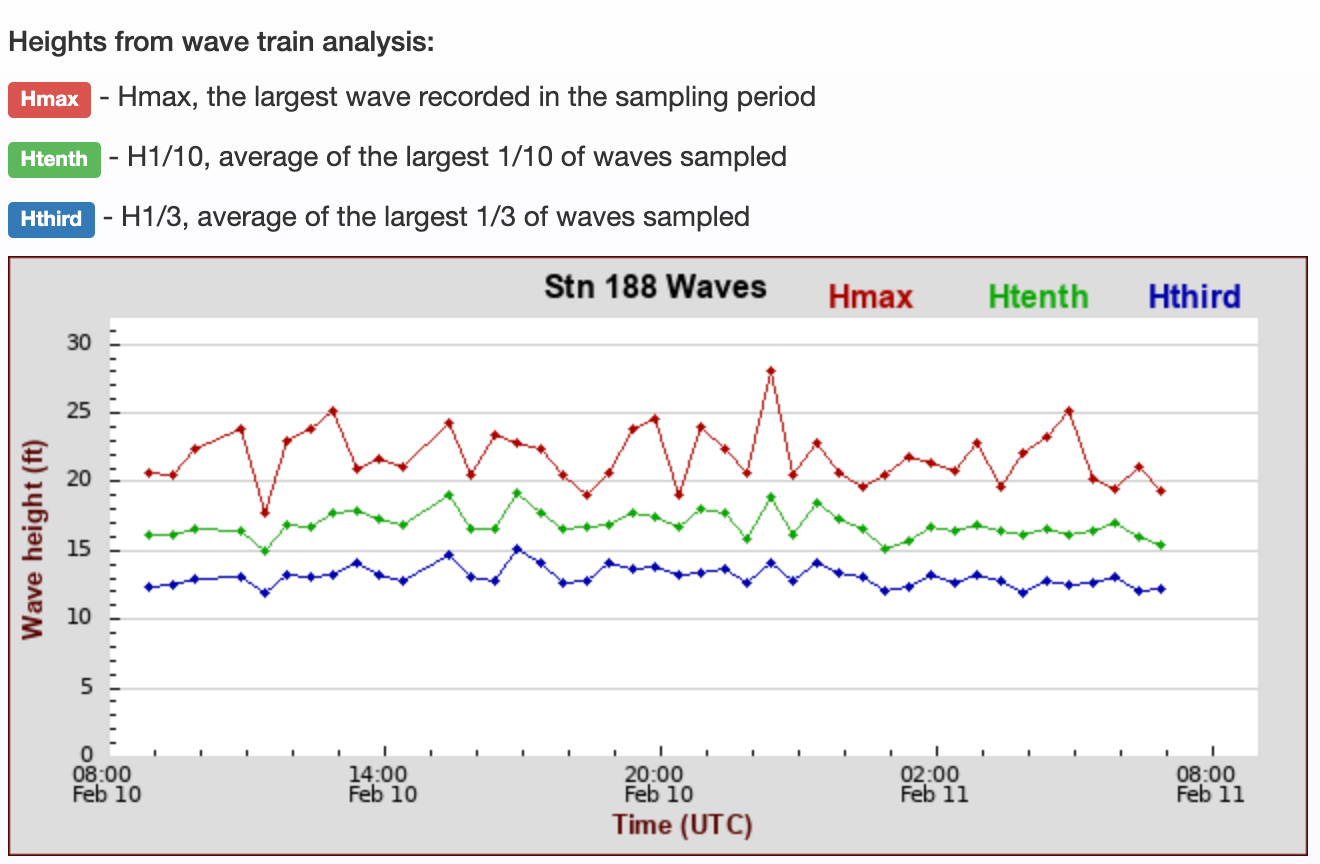

<div class="alert alert-info"><h1>Exercise 2.3: some reflections </h1></div>

1. What does the `distance` and the `prominence` parameters in function `sig.find_peaks` do (in the "find the peaks and troughs of the wave sequence" section)? How might our processing methods effect the wave height distribution results?
2. What are the appropriate durations of buoy data for the various analysis you performed? Think of roughly how much data you need for statistically meaningful wave height distribution and wave elevation distribution? Why would you not want too little data? Why would you not want too much data?
3. What are the appropriate bin sizes for the distribution plots? What would happen if you have too many or too few bins?
4. (Optional) If you still have time and energy, explore a bit more the daily and seasonal variability of waves at the stations you picked.